# Review ephys element structure

This notebook gives a brief overview of the workflow structure and introduce some useful DataJoint tools to facilitate the exploration.
+ DataJoint ephys directory needs to be defined before running this notebook, if you haven't set up the configuration, refer to notebook [00-Set_up_ephys_directories](00-Set_up_ephys_directories.ipynb).

To load the local configuration, we will change the directory to the package root.

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)



Let's start by importing the relevant modules.

In [35]:
import datajoint as dj
import pandas as pd
from bl_pipeline import lab, subject, acquisition
from bl_pipeline.ephys_element import ephys_element, probe_element

# Pipeline structure

+ dj.Diagram is a useful command to visualize the workflow structure and table dependencies.
+ Two element modules have been installed into `bl_pipeline`: `probe_element` and `ephys_element`

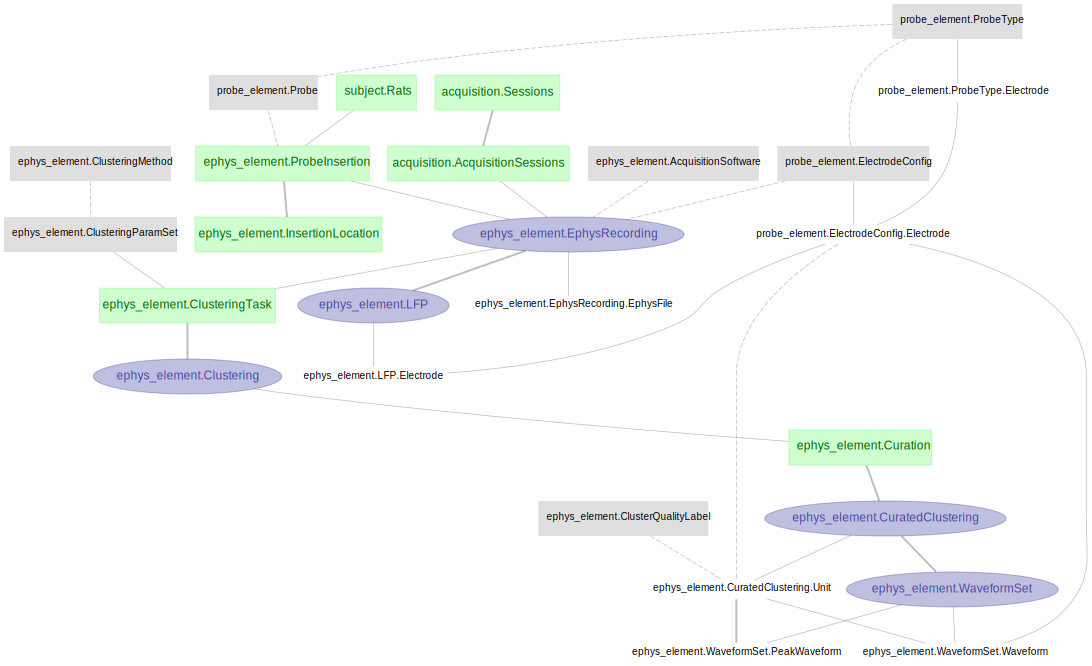

In [3]:
dj.Diagram(subject.Rats) + dj.Diagram(acquisition.Sessions) + dj.Diagram(probe_element) + dj.Diagram(ephys_element)

### As an example, we will work on the following session throughout the notebook:

In [5]:
sessid = 720464
session_key = (acquisition.Sessions & 'sessid='+str(sessid)).fetch1('KEY')
session_info  = (acquisition.Sessions & session_key).fetch1()
(acquisition.Sessions & session_key)

sessid Unique number assigned to each training session,session_rat ratname inherited from rats table,session_userid rat owner inherited from contacts table,session_rigid rig id number inherited from riginfo table,session_date date session started on,session_starttime time session started,session_endtime time session ended,protocol protocol name,"peh parsed events history state, poke, and wave times on each trial",n_done_trials number of trials completed,session_comments general comments,settings_file file containing settings saved at end of session,settings_path path to settings file,data_file file containing data saved at end of session,data_path path to data file,video_file file containing video saved at end of session,video_path path to video file,total_correct percent trials correct,right_correct percent right trials correct,left_correct percent left trials correct,percent_violations percent violation trials,protocol_data data structure containing selection of data from data and settings files,left_pokes number of left pokes performed,center_pokes number of center pokes performed,right_pokes number of right pokes performed,ip_addr IP address of rig session ran on,"foodpuck 1 if food was in the rig during the sessions, 0 if not"
720464,A230,abondy,2,2019-08-09,14:55:37,16:46:16,PBups,=BLOB=,677,,,,data_@PBups_Adrian_A230_190809a,C:\ratter\SoloData\Data\Adrian\A230\,video_@PBups_Adrian_A230_190809a.mp4,X:\RATTER\Video\Adrian\A230,0.85,0.93,0.78,0.29,=BLOB=,7570,2788,19600,128.112.219.182,1


## 1. Ephys element starts with table `ProbeInsertion`, as a child table of `subject.Rats`

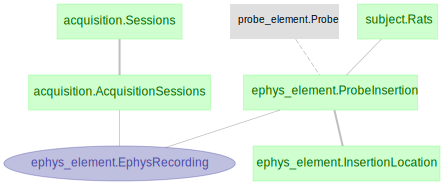

In [19]:
dj.Diagram(subject.Rats) + dj.Diagram(acquisition.Sessions) + dj.Diagram(probe_element.Probe) + \
(dj.Diagram(ephys_element.ProbeInsertion) + 1)

+ In this experiment with chronic probe insertions, the table `ephys_element.ProbeInsertion` directly depends on `subject.Rats`
+ Each entry in `acquisition.Sessions` represents an experimental session on a particular date.
+ Each entry in `ephys_element.EphysRecording` is for a particular probe insertion and a session.

## 2. Check which probes are on the DB and the one used on the session)

In [20]:
probe_element.ProbeType()

probe_type e.g. neuropixels_1.0
neuropixels 1.0 - 3A
neuropixels 1.0 - 3B
neuropixels 2.0 - MS
neuropixels 2.0 - SS


In [21]:
probe_element.Probe()

probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
17131306102,neuropixels 1.0 - 3B,
17131311342,neuropixels 1.0 - 3B,
17131311352,neuropixels 1.0 - 3B,
17131311621,neuropixels 1.0 - 3B,
17131311881,neuropixels 1.0 - 3B,
17131312042,neuropixels 1.0 - 3B,
17131312432,neuropixels 1.0 - 3B,
18005106831,neuropixels 1.0 - 3B,
18194823122,neuropixels 1.0 - 3B,
18194823302,neuropixels 1.0 - 3B,


### Probe inserted on the session's subject 

In [22]:
ephys_element.ProbeInsertion() & 'ratname="'+session_info['session_rat'] + '"'

"ratname Unique rat name, 1 letter 3 numbers",insertion_number,probe unique identifier for this model of probe (e.g. serial number),insertion_datetime
A230,0,18005106831,None


## 3. EphysRecording (Check files from recording)

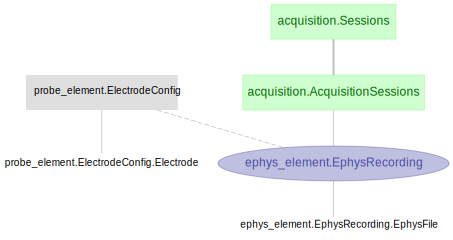

In [23]:
dj.Diagram(acquisition.Sessions) + (dj.Diagram(probe_element.ElectrodeConfig) + 1) + \
ephys_element.EphysRecording + ephys_element.EphysRecording.EphysFile

### Recording and files found for the session

In [24]:
ephys_element.EphysRecording() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
720464,A230,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.5


In [25]:
ephys_element.EphysRecording.EphysFile() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,file_path filepath relative to root data directory
720464,A230,0,Adrian/A230/A230_2019-08-09_g0/A230_2019-08-09_g0_imec0/A230_2019-08-09_g0_t0.imec0.ap.meta


### Electrode configuration for the session

In [28]:
ephys_element.EphysRecording() * probe_element.ElectrodeConfig()  & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name
720464,A230,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.5,neuropixels 1.0 - 3B,0-383


## 4. ClusteringTask 

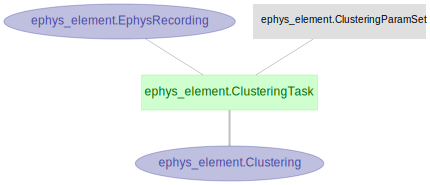

In [29]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringParamSet + ephys_element.ClusteringTask + \
ephys_element.Clustering

The next major table in the ephys pipeline is the `ClusteringTask`.

+ In the future release of ephys elements, we will aim to trigger Clustering within the workflow, and register an entry in `ClusteringTask` is a manual step to let the pipeline know that there is a Clustering Task to be processed.

+ Currently, we have not supported the processing of Kilosort2 within the workflow. `ClusteringTask` is a place holder
indicating a Kilosort2 clustering task is finished and the clustering results are ready for processing. 

+ The `ClusteringTask` table depends on the table `ClusteringParamSet`, which are the parameters used for sorting

### Clustering Task and params for the session

In [31]:
ephys_element.ClusteringTask() * ephys_element.ClusteringParamSet() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation",clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
720464,A230,0,0,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,load,kilosort2,Spike sorting using Kilosort2,83f93e90-d8e0-1dca-5b2c-f65e2b0b3c61,=BLOB=


In [42]:
params = (ephys_element.ClusteringTask() * ephys_element.ClusteringParamSet() & session_key).fetch1('params')
pd.Series(params)

fs                        30000
fshigh                      150
minfr_goodchannels          0.1
Th                      [10, 4]
lam                          10
AUCsplit                    0.9
minFR                      0.02
momentum              [20, 400]
sigmaMask                    30
ThPr                          8
spkTh                        -6
reorder                       1
nskip                        25
GPU                           1
Nfilt                      1024
nfilt_factor                  4
ntbuff                       64
whiteningRange               32
nSkipCov                     25
scaleproc                   200
nPCs                          3
useRAM                        0
dtype: object

The `Clustering` table now validates the Kilosort2 outcomes.

In [44]:
ephys_element.Clustering & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,clustering_time time of generation of this set of clustering results,package_version
720464,A230,0,0,2021-02-19 01:50:51,


## 5. Curations

These clustering results are either directly from Kilosort2 or with manual curation. Both ways share the same format of files. In the element, there is a `Curation` table that saves this information.

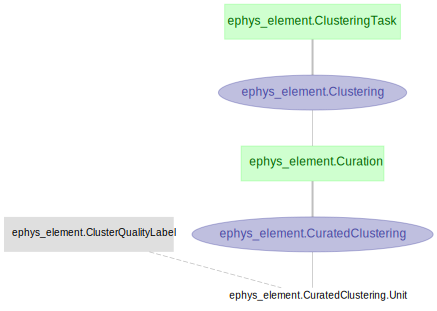

In [78]:
dj.Diagram(ephys_element.ClusteringTask) + 3 + ephys_element.CuratedClustering.Unit + ephys_element.ClusterQualityLabel()

### Curations for session

In [47]:
ephys_element.Curation() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,curation_note
720464,A230,0,0,1,2021-02-19 01:50:51,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,0,0,
720464,A230,0,0,2,2021-02-19 01:50:51,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,0,0,
720464,A230,0,0,3,2021-02-19 01:50:51,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,0,0,
720464,A230,0,0,4,2021-02-19 01:50:51,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,0,0,
720464,A230,0,0,5,2021-02-19 01:50:51,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,0,0,
720464,A230,0,0,6,2021-02-19 01:50:51,Adrian/A230/2019-08-09/A230_2019-08-09_g0_imec0,0,0,


In [49]:
ephys_element.CuratedClustering & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,curation_id


### Quality labels for all units on the DB

In [81]:
ephys_element.ClusterQualityLabel()

cluster_quality_label,cluster_quality_description
good,single unit
mua,multi-unit activity
noise,bad unit
ok,"probably a single unit, but could be contaminated"


### Units found in the session in first curation

In [82]:
cur_query= dict()
cur_query['curation_id'] = 1

ephys_element.CuratedClustering.Unit() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"


## 6. LFPs

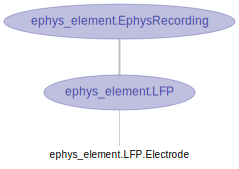

In [83]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.LFP + ephys_element.LFP.Electrode

In [84]:
ephys_element.LFP & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,lfp_sampling_rate (Hz),lfp_time_stamps (s) timestamps with respect to the start of the recording (recording_timestamp),"lfp_mean (uV) mean of LFP across electrodes - shape (time,)"


In [85]:
ephys_element.LFP.Electrode & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",lfp (uV) recorded lfp at this electrode


## 7. Waveforms

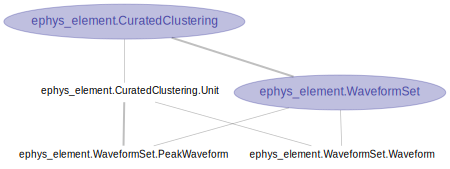

In [86]:
dj.Diagram(ephys_element.CuratedClustering)+2

In [87]:
ephys_element.WaveformSet() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,curation_id


+ Waveform: `Waveform` table computes the average spike waveform of the channel with peak amplites. It takes a while to populate depending on the size of the data.

In [88]:
ephys_element.WaveformSet.Waveform & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",waveform_mean (uV) mean waveform across spikes of the given unit,waveforms (uV) (spike x sample) waveforms of a sampling of spikes at the given electrode for the given unit


In [89]:
ephys_element.WaveformSet.PeakWaveform & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,curation_id,unit,peak_electrode_waveform (uV) mean waveform for a given unit at its representative electrode
